In [1]:
!pip install contractions
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e8cd1a817015377329a6ae9aeb0cdb90cc762b37b35a325cfe584df8a6125428
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl siz

In [2]:
import pandas as pd
import unicodedata
import re
import contractions
import string

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [3]:
df = pd.read_parquet('/content/drive/MyDrive/final_twitter_data.parquet')
df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type
0,2021-06-20T21:33:30.000Z,1406726930888540160,1406726930888540160,2981738470,RT @davidlohner: #IchbinHanna und schreibe auc...,7,0,0,0,"[{'type': 'retweeted', 'id': '1406714909258362...",['IchbinHanna'],retweet
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalist:innen über #IchbinHa...,9,1,62,4,[],['IchbinHanna'],original
2,2021-06-20T20:50:42.000Z,1406716159064485895,1406716159064485895,2981738470,RT @DrKEichhorn: Wieder ein Artikel ohne echte...,16,0,0,0,"[{'type': 'retweeted', 'id': '1406697315159752...",[],retweet
3,2021-06-20T17:56:03.000Z,1406672208056012807,1406672208056012807,2981738470,RT @chrismeyer2203: So sieht es aus ⬇️ oder an...,7,0,0,0,"[{'type': 'retweeted', 'id': '1406175728190865...",[],retweet
4,2021-06-20T17:53:00.000Z,1406671439328055301,1406671439328055301,2981738470,RT @steffen_siegel: Modelle einer Universitäts...,17,0,0,0,"[{'type': 'retweeted', 'id': '1406666454368493...",[],retweet


In [4]:
import urllib

#url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-de/master/stopwords-de.txt'
url = 'https://raw.githubusercontent.com/solariz/german_stopwords/master/german_stopwords_full.txt'
filename = url.rsplit('/', 1)[-1]
datadir = '/content/'

urllib.request.urlretrieve(url, datadir + 'stopwords-de.txt')

('/content/stopwords-de.txt', <http.client.HTTPMessage at 0x7f72a08b7670>)

In [5]:
new_df = df.loc[df['tweet_type'] != 'retweet']
new_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalist:innen über #IchbinHa...,9,1,62,4,[],['IchbinHanna'],original
5,2021-06-20T16:17:25.000Z,1406647386542325764,1406647386542325764,2981738470,☝️⬇️ #IchbinHanna #PeerReview https://t.co/PFN...,0,0,1,0,"[{'type': 'quoted', 'id': '1406620276822061057'}]","['IchbinHanna', 'PeerReview']",original
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread ⬇️ about the cruel #precarity in German...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,"Liebe @unidue und Forsa - schön, dass ihr euch...",0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread ⬇️ zu #Machtmissbrauch in der...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original


In [6]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

new_df.text = new_df.text.apply(remove_emojis)
new_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalist:innen über #IchbinHa...,9,1,62,4,[],['IchbinHanna'],original
5,2021-06-20T16:17:25.000Z,1406647386542325764,1406647386542325764,2981738470,#IchbinHanna #PeerReview https://t.co/PFNrovEOAS,0,0,1,0,"[{'type': 'quoted', 'id': '1406620276822061057'}]","['IchbinHanna', 'PeerReview']",original
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel #precarity in German #...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,"Liebe @unidue und Forsa - schön, dass ihr euch...",0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu #Machtmissbrauch in der #...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original


In [7]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=d94cc8377c62f7695f549874f2dd04aacb344710ad50f31b9a242e423c38e353
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [8]:
from langdetect import detect

In [9]:
def detect_my(text):
  try:
    return detect(text)
  except:
    return "unknown"

In [10]:
new_df['language']=new_df['text'].apply(detect_my)

<ipython-input-10-b811955c4c3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['language']=new_df['text'].apply(detect_my)


In [11]:
Df = new_df.drop_duplicates(subset=['tweet_id'])

In [12]:
Df['language'].value_counts()

de         42739
en          6139
sv          1160
tl           205
unknown      122
fr           110
it            76
id            64
nl            51
es            39
af            20
fi            19
pl            18
no            17
da            13
cy            13
so            12
sw            12
et            11
pt            11
ca             9
ar             8
tr             8
cs             8
hr             3
sk             3
hu             3
hi             2
fa             2
vi             2
ro             2
th             1
sq             1
sl             1
ru             1
lv             1
Name: language, dtype: int64

In [13]:
Df.shape

(50906, 13)

In [14]:
Df

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalist:innen über #IchbinHa...,9,1,62,4,[],['IchbinHanna'],original,de
5,2021-06-20T16:17:25.000Z,1406647386542325764,1406647386542325764,2981738470,#IchbinHanna #PeerReview https://t.co/PFNrovEOAS,0,0,1,0,"[{'type': 'quoted', 'id': '1406620276822061057'}]","['IchbinHanna', 'PeerReview']",original,nl
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel #precarity in German #...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,"Liebe @unidue und Forsa - schön, dass ihr euch...",0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu #Machtmissbrauch in der #...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308293,2021-09-17T14:36:31.000Z,1438874511605125123,1438766234489794560,743696568939753475,@asayeed @mjpost I still can't get over how th...,0,1,0,0,"[{'type': 'replied_to', 'id': '143887433770928...",[],original,en
308311,2021-08-25T04:56:31.000Z,1430393629651177473,1430093188757401618,1134768684315160577,@VinciGusta WissZeitVG Maximaldauer erreicht?\...,0,0,0,0,"[{'type': 'replied_to', 'id': '143009318875740...",[],original,de
308323,2022-08-13T13:39:47.000Z,1558448232631762944,1558448232631762944,329984940,fellow profs: #academicprecarity is OUR proble...,2,0,4,0,"[{'type': 'quoted', 'id': '1556700609155317761'}]",['academicprecarity'],original,en
308326,2021-09-02T19:41:11.000Z,1433515364932067338,1433515364932067338,3005636663,"@AGH_Berlin beschließt neues ""Gesetz zur Stärk...",1,0,6,0,[],"['Wissenschaft', 'Postdocs', 'Promotionsrecht'...",original,de


In [15]:
de_df = Df[Df.language == 'de']
de_df.shape

(42739, 13)

In [16]:
de_df

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalist:innen über #IchbinHa...,9,1,62,4,[],['IchbinHanna'],original,de
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,"Liebe @unidue und Forsa - schön, dass ihr euch...",0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu #Machtmissbrauch in der #...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de
21,2021-06-18T07:52:36.000Z,1405795569273131011,1405795569273131011,1132055796571877376,Wir können ja mal einen #FollowFriday für #Ich...,4,0,16,0,"[{'type': 'quoted', 'id': '1405617868734148610'}]","['FollowFriday', 'IchbinHanna', 'WissZeitVG', ...",original,de
22,2021-06-18T02:42:56.000Z,1405717636999155717,1405717636999155717,2981738470,"Das ist übrigens ein Punkt, der mir bei #Ichbi...",1,0,6,0,"[{'type': 'quoted', 'id': '1405460325437149186'}]",['IchbinHanna'],original,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308278,2022-08-15T09:31:53.000Z,1559110620972285953,1559109649995124738,151775715,"Hätte nicht gedacht, dass ich das nochmal sage...",0,2,13,0,"[{'type': 'replied_to', 'id': '155910964999512...","['IchBinNichtMehrHanna', 'IchBinHanna']",original,de
308279,2022-08-15T09:28:02.000Z,1559109649995124738,1559109649995124738,151775715,Frisch zurück aus dem Urlaub gibt's some perso...,0,25,108,1,[],[],original,de
308311,2021-08-25T04:56:31.000Z,1430393629651177473,1430093188757401618,1134768684315160577,@VinciGusta WissZeitVG Maximaldauer erreicht?\...,0,0,0,0,"[{'type': 'replied_to', 'id': '143009318875740...",[],original,de
308326,2021-09-02T19:41:11.000Z,1433515364932067338,1433515364932067338,3005636663,"@AGH_Berlin beschließt neues ""Gesetz zur Stärk...",1,0,6,0,[],"['Wissenschaft', 'Postdocs', 'Promotionsrecht'...",original,de


In [116]:
en_df = Df[Df.language == 'en']
en_df.shape

(6139, 13)

In [117]:
en_df

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel #precarity in German #...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,Thread summarizing a video by the German Fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,On job #precarity in German #academia and it's...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,#AcademicTwitter @AcademicChatter #acertaindeg...,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,#IchbinHanna: German researchers without a per...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308092,2022-10-04T14:01:01.000Z,1577297743663583232,1577176553666273280,2474312910,@astrodicticum #IchbinHanna,0,0,0,0,"[{'type': 'replied_to', 'id': '157717655366627...",['IchbinHanna'],original,en
308243,2022-09-13T08:48:00.000Z,1569608824117465088,1569608824117465088,1554860518900486144,The @HIFMB_OL together with the @SociedadCerfa...,3,0,9,0,[],['WissZeitGesetz'],original,en
308292,2021-09-17T14:38:18.000Z,1438874960110424072,1438766234489794560,32800037,@ryandcotterell @mjpost there's no studies on ...,0,1,0,0,"[{'type': 'replied_to', 'id': '143887451160512...",[],original,en
308293,2021-09-17T14:36:31.000Z,1438874511605125123,1438766234489794560,743696568939753475,@asayeed @mjpost I still can't get over how th...,0,1,0,0,"[{'type': 'replied_to', 'id': '143887433770928...",[],original,en


### GERMAN PRE-PROCESS

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...


['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
def remove_mentions_and_tags(text): #Removing mentions and hashtags
    text = re.sub(r'@\S*', '', text)
    return re.sub(r'#\S*', '', text)

de_df.text = de_df.text.apply(remove_mentions_and_tags)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
de_df['text'] = de_df['text'].str.replace(r'[^\w\s]+', '')

<ipython-input-21-036435de67c9>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  de_df['text'] = de_df['text'].str.replace(r'[^\w\s]+', '')
<ipython-input-21-036435de67c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df['text'] = de_df['text'].str.replace(r'[^\w\s]+', '')


In [50]:
def to_lowercase(text):
    return text.lower()

de_df.text = de_df.text.apply(to_lowercase)

de_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,wenn wirtschaftsjounalistinnen schreiben amp d...,9,1,62,4,[],['IchbinHanna'],original,de
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,liebe forsa schön per umfrage interessiert die...,0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,wichtiger thread arbeitsverträge begünstigt ht...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de
21,2021-06-18T07:52:36.000Z,1405795569273131011,1405795569273131011,1132055796571877376,wir ja mal wer macht httpstcosjdilpwjwj,4,0,16,0,"[{'type': 'quoted', 'id': '1405617868734148610'}]","['FollowFriday', 'IchbinHanna', 'WissZeitVG', ...",original,de
22,2021-06-18T02:42:56.000Z,1405717636999155717,1405717636999155717,2981738470,das übrigens punkt einfach kurz kommt die akad...,1,0,6,0,"[{'type': 'quoted', 'id': '1405460325437149186'}]",['IchbinHanna'],original,de


In [22]:
de_df['text'] = de_df['text'].str.replace('\d+', '') #removing number from text

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-22-fd1b9dd72fe4>:1: DeprecationWarning: invalid escape sequence \d
  de_df['text'] = de_df['text'].str.replace('\d+', '') #removing number from text
<ipython-input-22-fd1b9dd72fe4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  de_df['text'] = de_df['text'].str.replace('\d+', '') #removing number from text
<ipython-input-22-fd1b9dd72fe4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df['text'] = de_df['text'].str.replace('\d+', '') #removing number from text


https://www.thoughtco.com/capitalization-in-german-4069437 

In [25]:
#compound words
from pprint import pprint

PAT_COMPOUND = re.compile(r'\w+[-]\w+')

compounds = de_df['text'].apply(lambda doc: [match.group() for match in PAT_COMPOUND.finditer(doc)])

In [26]:
#Tokenization
from gensim.utils import tokenize

def tokens(documents):
    """Convert all documents into a list of lowercase tokens using Gensim's tokenize() function."""
    return [tokenize(doc, lower=True) for doc in documents]

tokens = [[t for t in tokenize(doc, lower=True)] for doc in de_df['text']]

In [27]:
#creation of n-gram model

from gensim.models.phrases import Phrases, Phraser

bigram_model = Phrases(tokens, min_count=1, threshold=100)

bigrams = list(bigram_model[tokens])
trigram_model = Phrases(bigrams, min_count=1, threshold=100)

bigram_model = Phraser(bigram_model)
trigram_model = Phraser(trigram_model)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [28]:
def n_grams(documents):
    return trigram_model[list(bigram_model[documents])]

In [29]:
# nltk stop words, extra stop words
german_stop_words = stopwords.words('german')
en_stop_words = stopwords.words('english')

stopwords_filename = '/content/stopwords-de.txt'

with open(stopwords_filename) as f:
    stopwords = [line for line in f.read().splitlines() if not line.startswith(';')]

# add more stopwords
more_stopwords = 'anbelangt dingen genauso gerne hierzu hinzu liebe nahezu nunmehr punkt relativ sodass sozusagen trotz übrigen vielfach vielfache vielmehr voraussichtlich wahrlich wahrscheinlich zuvor'
stopwords.extend(more_stopwords.split())

# use dictionary for better performance
stopwordsdict = dict.fromkeys(stopwords, 1)

def remove_stopwords(tokens):
    return [[word for word in doc if word not in stopwordsdict] for doc in tokens]

def stop_word_de_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in german_stop_words])

def stop_word_en_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in en_stop_words])

de_df.text = de_df.text.apply(stop_word_de_removal)
de_df.text = de_df.text.apply(stop_word_en_removal)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [30]:
from nltk.stem.cistem import Cistem

stemmer = Cistem(True)

# even do stemming on each part of the n-grams
def stemming(tokens):
    return [['_'.join([stemmer.stem(part) for part in word.split('_')]) for word in doc] for doc in tokens]

In [31]:
tokens_nostop = remove_stopwords(tokens)
tokens_ngram  = n_grams(tokens_nostop)
tokens_stem   = stemming(tokens_ngram)

texts = tokens_ngram

In [33]:
from pprint import pprint
# most frequent compound words after pre-processing
ngrams = [[word for word in doc if '_' in word] for doc in tokens_ngram]
stems  = [[word for word in doc if '_' in word] for doc in tokens_stem]

In [34]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)

print(dictionary)

Dictionary(85612 unique tokens: ['aktienmarkt', 'amp', 'einsteigen', 'erinnern', 'finanzkrisehttpstcoeckyjogs']...)


In [35]:
dfs_desc = sorted(dictionary.dfs.items(), key=lambda t: t[1], reverse=True)

print('--- Most Frequent Tokens in X Documents', dictionary.num_docs, 'Documents ---')
for (k,v) in dfs_desc[0:10]: print('{freq}: {token}'.format(token=dictionary[k], freq=v))

print('--- Least Frequent Tokens in X Documents', dictionary.num_docs, 'Documents ---')
for (k,v) in dfs_desc[-10:]: print('{freq}: {token}'.format(token=dictionary[k], freq=v))

--- Most Frequent Tokens in X Documents 42739 Documents ---
3521: amp
3294: wissenschaft
1624: forschung
1410: jahre
1318: jahren
1298: wisszeitvg
1270: system
1252: dauerstellen
1237: stellen
1214: zeit
--- Least Frequent Tokens in X Documents 42739 Documents ---
1: hannos
1: cartographer
1: millennium
1: ichbinreyhan
1: httpstcocglgvkbbxx
1: httpstcocnhgxpuaic
1: maximaldauer
1: httpstcoeczhpzlqv
1: hochschulverband_dhv
1: httpstcocynfgocvr


In [36]:
print('Filtering extreme tokens')
freq_before = len(dictionary)
dictionary.filter_extremes(no_below=5, no_above=0.3)
print('{} token before -> {} after'.format(freq_before, len(dictionary)))

Filtering extreme tokens
85612 token before -> 10926 after


In [37]:
dfs_desc = sorted(dictionary.dfs.items(), key=lambda t: t[1], reverse=True)

print('--- Most Frequent Token Occurrences in', dictionary.num_docs, 'Documents ---')
for (k,v) in dfs_desc[0:10]: print('{freq}: {token}'.format(token=dictionary[k], freq=v))

print('--- Least Frequent Token Occurrences in', dictionary.num_docs, 'Documents ---')
for (k,v) in dfs_desc[-10:]: print('{freq}: {token}'.format(token=dictionary[k], freq=v))

--- Most Frequent Token Occurrences in 42739 Documents ---
3521: amp
3294: wissenschaft
1624: forschung
1410: jahre
1318: jahren
1298: wisszeitvg
1270: system
1252: dauerstellen
1237: stellen
1214: zeit
--- Least Frequent Token Occurrences in 42739 Documents ---
5: pandemiebedingungen
5: allianz
5: uhh
5: vmtl
5: tarifrunden
5: eingreifen
5: kartoffeln
5: dauerthema
5: wettbewerbsvorteil
5: prominente


In [38]:
print('Creating Corpus')
corpus_bow = [dictionary.doc2bow(doc) for doc in texts]

Creating Corpus


In [51]:
from gensim.models import LdaModel, CoherenceModel

num_topics = 15

In [52]:
from gensim import corpora, models

def compute_lda(corpus, id2word, num_topics):
    
    print('Computing LDA for', num_topics, 'topics...')
    model_lda = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics) 
    return model_lda

def compute_coherence(model, corpus, id2word, num_topics, coherence='u_mass'):
    cm = models.CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence=coherence)
    return cm.get_coherence()

In [ ]:
de_model_lda = LdaModel(corpus_bow, id2word=dictionary, num_topics=num_topics)

In [54]:
coherence = compute_coherence(de_model_lda, corpus_bow, dictionary, num_topics)
print("coherence: {:.3f}".format(coherence))

coherence: -8.405


In [55]:
def get_lda_topics(model, num_topics, top_n_words):
     word_dict = {}
     for i in range(num_topics):
         word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in model.show_topic(i, topn = top_n_words)];
 
     return pd.DataFrame(word_dict)
get_lda_topics(de_model_lda,15,10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,forschung,dauerstellen,deutschland,wisszeitvg,berlin,passiert,perspektive,dauerstellen,amp,d,politik,problem,uhr,jahre,amp
1,thread,frage,jahren,evaluation,a,unis,bundestag,daueraufgaben,wissenschaft,arbeit,denken,wissenschaftler,hanna,promotion,forschung
2,bildung,system,nachwuchs,reform,entfristung,me,wisszeitvg,wissenschaft,forschung,hochschule,ging,wissenschaft,wissenschaft,richtig,wissenschaft
3,führt,reden,professur,ichbinhanna,nächsten,perspektiven,glaube,amp,hochschulen,grund,hashtag,karriere,heißt,jahren,lehre
4,helfen,geld,freue,pandemie,ne,ok,stellen,stellen,beitrag,nix,fehlt,wissenschaftlerinnen,wochen,stelle,wisszeitvg
5,studiert,welt,fdp,fragen,gespräch,professuren,unterstützen,s,arbeitsbedingungen,wissenschaft,wirtschaft,debatte,zeit,teil,frauen
6,unterstützt,leben,lese,ergebnisse,promotion,studierende,berliner,universitäten,lehre,uni,professoren,forderungen,wichtige,lang,unis
7,jobs,n,moment,ernsthaft,diskutiert,doktoranden,uni,zb,gesellschaft,bekommen,infos,via,arbeitsbedingungen,echt,hochschulen
8,offenbar,wissenschaft,vergleich,gegenteil,stelle,system,na,kommentar,diskussion,rahmen,thema,verbessern,wünsche,uni,verwaltung
9,prof,stellen,uni,gedacht,freuen,naja,stelle,hochschulen,ändern,voll,lage,hanna,amp,bekommen,befristet


In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(de_model_lda, corpus_bow, dictionary, mds='mmds', R=30)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
81     0.455272  0.259561       1        1  1.497538
23    -0.039756 -0.499576       2        1  1.250441
66    -0.104634 -0.426404       3        1  1.186870
42    -0.370957 -0.394479       4        1  1.134658
72     0.228444 -0.470805       5        1  1.081255
...         ...       ...     ...      ...       ...
32     0.127078  0.249630     146        1  0.373991
126    0.186668  0.014583     147        1  0.372061
107   -0.100118  0.204802     148        1  0.366265
110   -0.125341 -0.007969     149        1  0.356502
93    -0.058515  0.321180     150        1  0.333033

[150 rows x 5 columns], topic_info=                 Term         Freq        Total  Category  logprob  loglift
38       dauerstellen  1751.000000  1751.000000   Default  30.0000  30.0000
283             jahre  1612.000000  1612.000000   Default  29.0000  29.0000
212         forschung  2190.000000  2190.000000   Default  28.0000  28.0000
254       hochschulen  1377.000000  1377.000000   Default  27.0000  27.0000
673              unis  1367.000000  1367.000000   Default  26.0000  26.0000
...               ...          ...          ...       ...      ...      ...
1446          signale     6.521704     7.837985  Topic150  -5.0471   5.5208
3060  problematischen     6.268415     7.565236  Topic150  -5.0867   5.5166
1469    gleichgesetzt     6.043707     7.340528  Topic150  -5.1232   5.5103
120            system    21.023358  1618.442211  Topic150  -3.8766   1.3611
867        wisszeitvg     6.417311  2171.142709  Topic150  -5.0632  -0.1193

[4983 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2075     86  0.995519            a
1133     30  0.939402   abbekommen
2610    122  0.987462        abend
2006    137  0.700031     abgebaut
1360     29  0.973079  abgebrochen
...     ...       ...          ...
1995     51  0.954481   überzeugen
1857     49  0.981594    überzeugt
3662    111  0.965295       üblich
4233    127  0.922960      übliche
4180     50  0.972245     üblichen

[5376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[82, 24, 67, 43, 73, 14, 90, 38, 103, 122, 64, 91, 61, 139, 102, 26, 52, 133, 55, 99, 62, 134, 75, 83, 98, 18, 116, 87, 146, 32, 130, 118, 112, 86, 92, 28, 23, 135, 11, 79, 141, 22, 45, 128, 13, 100, 115, 71, 56, 101, 60, 29, 137, 50, 57, 105, 85, 15, 19, 96, 104, 150, 31, 21, 74, 114, 8, 117, 17, 40, 120, 63, 16, 36, 138, 25, 140, 46, 68, 89, 51, 149, 144, 148, 129, 125, 4, 2, 136, 27, 35, 37, 42, 124, 121, 107, 59, 34, 44, 147, 70, 12, 47, 3, 10, 5, 95, 1, 41, 109, 123, 6, 132, 106, 119, 84, 49, 7, 72, 54, 80, 88, 58, 39, 110, 9, 131, 65, 78, 93, 113, 81, 48, 53, 126, 69, 77, 30, 20, 143, 97, 76, 66, 145, 142, 33, 127, 108, 111, 94])

In [ ]:
coh_acc = []
for i in range(10, 150, 15):
  num_top = i
  de_model_lda_var = LdaModel(corpus_bow, id2word=dictionary, num_topics=num_top)
  coherence_var = compute_coherence(de_model_lda_var, corpus_bow, dictionary, num_top)
  print("coherence u_mass: {:.3f}".format(coherence_var))
  coh_acc.append(coherence_var)


In [59]:
for i in range(len(coh_acc)):
  j = []
  for k in range(10,150,15):
    j.append(k)
  print("topic # ", j[i]," coherence u_mass value = ",coh_acc[i])

topic #  10  coherence u_mass value =  -6.845787568580302
topic #  25  coherence u_mass value =  -10.4640472228121
topic #  40  coherence u_mass value =  -12.850001730747739
topic #  55  coherence u_mass value =  -13.62216863608281
topic #  70  coherence u_mass value =  -14.415237296494848
topic #  85  coherence u_mass value =  -14.926283875438182
topic #  100  coherence u_mass value =  -15.002471950833758
topic #  115  coherence u_mass value =  -15.577224097059437
topic #  130  coherence u_mass value =  -16.07985223373287
topic #  145  coherence u_mass value =  -16.399401123881017


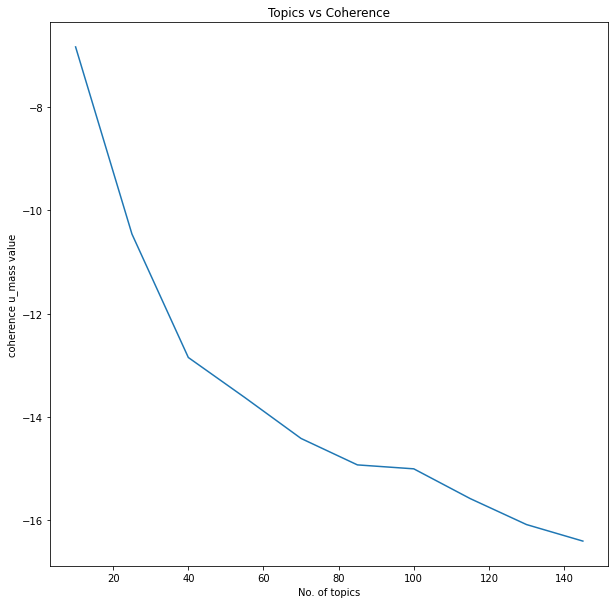

In [75]:
import matplotlib.pyplot as plt
import numpy as np

x = [10,25,40,55,70,85,100,115,130,145]
y= [-6.845787568580302,-10.4640472228121,-12.850001730747739,-13.62216863608281,-14.415237296494848,-14.926283875438182,-15.002471950833758,-15.577224097059437,-16.07985223373287,-16.399401123881017]

plt.subplots(figsize=(10, 10))
plt.plot(x, y)
plt.xlabel("No. of topics") # add X-axis label
plt.ylabel("coherence u_mass value") # add Y-axis label
plt.title("Topics vs Coherence") # add title
plt.show()

### ENGLISH PRE-PROCESSING

In [39]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [118]:
def to_lowercase(text):
    return text.lower()

en_df.text = en_df.text.apply(to_lowercase)

en_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,thread about the cruel #precarity in german #...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,thread summarizing a video by the german fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,on job #precarity in german #academia and it's...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,#academictwitter @academicchatter #acertaindeg...,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,#ichbinhanna: german researchers without a per...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en


In [119]:
def remove_mentions_and_tags(text): #Removing mentions and hashtags
    text = re.sub(r'@\S*', '', text)
    return re.sub(r'#\S*', '', text)

en_df.text = en_df.text.apply(remove_mentions_and_tags)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [120]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [121]:
en_df['text'] = en_df['text'].str.replace(r'[^\w\s]+', '')

<ipython-input-121-87f5f943dbde>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  en_df['text'] = en_df['text'].str.replace(r'[^\w\s]+', '')
<ipython-input-121-87f5f943dbde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_df['text'] = en_df['text'].str.replace(r'[^\w\s]+', '')


In [122]:
en_df['text'] = en_df['text'].str.replace('\d+', '')

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-122-e1b314f26fb2>:1: DeprecationWarning: invalid escape sequence \d
  en_df['text'] = en_df['text'].str.replace('\d+', '')
<ipython-input-122-e1b314f26fb2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  en_df['text'] = en_df['text'].str.replace('\d+', '')
<ipython-input-122-e1b314f26fb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_df['text'] = en_df['text'].str.replace('\d+', '')


In [123]:
en_df

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,thread about the cruel in german the debate...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,thread summarizing a video by the german fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,on job in german and its impact on life and...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,httpstcoxtqihqyv,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,german researchers without a permanent post i...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308092,2022-10-04T14:01:01.000Z,1577297743663583232,1577176553666273280,2474312910,,0,0,0,0,"[{'type': 'replied_to', 'id': '157717655366627...",['IchbinHanna'],original,en
308243,2022-09-13T08:48:00.000Z,1569608824117465088,1569608824117465088,1554860518900486144,the together with the host the seminar forev...,3,0,9,0,[],['WissZeitGesetz'],original,en
308292,2021-09-17T14:38:18.000Z,1438874960110424072,1438766234489794560,32800037,theres no studies on how it made it worse an...,0,1,0,0,"[{'type': 'replied_to', 'id': '143887451160512...",[],original,en
308293,2021-09-17T14:36:31.000Z,1438874511605125123,1438766234489794560,743696568939753475,i still cant get over how they titled their ...,0,1,0,0,"[{'type': 'replied_to', 'id': '143887433770928...",[],original,en


In [124]:
english_stop_words = stopwords.words('english')

def stop_word_en_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in english_stop_words])

en_df.text = en_df.text.apply(stop_word_en_removal)
en_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,thread cruel german debate started days ago co...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,thread summarizing video german federal minist...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,job german impact life httpstcosfzrifse,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,httpstcoxtqihqyv,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,german researchers without permanent post comm...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en


In [125]:
#compound words
from pprint import pprint

PAT_COMPOUND = re.compile(r'\w+[-]\w+')

en_compounds = en_df['text'].apply(lambda doc: [match.group() for match in PAT_COMPOUND.finditer(doc)])

In [126]:
#Tokenization
from gensim.utils import tokenize

def en_tokens(documents):
    """Convert all documents into a list of lowercase tokens using Gensim's tokenize() function."""
    return [tokenize(doc, lower=True) for doc in documents]

en_tokens = [[t for t in tokenize(doc, lower=True)] for doc in en_df['text']]

In [127]:
#creation of n-gram model

from gensim.models.phrases import Phrases, Phraser

en_bigram_model = Phrases(en_tokens, min_count=1, threshold=100)

en_bigrams = list(en_bigram_model[tokens])
en_trigram_model = Phrases(en_bigrams, min_count=1, threshold=100)

en_bigram_model = Phraser(en_bigram_model)
en_trigram_model = Phraser(en_trigram_model)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [128]:
def en_n_grams(documents):
    return en_trigram_model[list(en_bigram_model[documents])]

In [146]:
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
en_stopwords = list(stopwords_list.decode().splitlines()) 
en_stopwords.append('amp')

def en_remove_stopwords(tokens):
  return [[word for word in doc if word not in en_stopwords] for doc in tokens]

In [147]:
from nltk.stem.cistem import Cistem

en_stemmer = Cistem(True)

# even do stemming on each part of the n-grams
def en_stemming(tokens):
    return [['_'.join([en_stemmer.stem(part) for part in word.split('_')]) for word in doc] for doc in tokens]

In [148]:
en_tokens_nostop = en_remove_stopwords(en_tokens)
en_tokens_ngram  = en_n_grams(en_tokens_nostop)
en_tokens_stem   = en_stemming(en_tokens_ngram)

en_texts = en_tokens_ngram

In [149]:
from pprint import pprint
# most frequent compound words after pre-processing
en_ngrams = [[word for word in doc if '_' in word] for doc in en_tokens_ngram]
en_stems  = [[word for word in doc if '_' in word] for doc in en_tokens_stem]

In [150]:
from gensim import corpora

en_dictionary = corpora.Dictionary(en_texts)

print(en_dictionary)

Dictionary(16156 unique tokens: ['ago', 'continues', 'cruel', 'days', 'debate']...)


In [151]:
en_dfs_desc = sorted(en_dictionary.dfs.items(), key=lambda t: t[1], reverse=True)

print('--- Most Frequent Tokens in X Documents', en_dictionary.num_docs, 'Documents ---')
for (k,v) in en_dfs_desc[0:10]: print('{freq}: {token}'.format(token=en_dictionary[k], freq=v))

print('--- Least Frequent Tokens in X Documents', en_dictionary.num_docs, 'Documents ---')
for (k,v) in en_dfs_desc[-10:]: print('{freq}: {token}'.format(token=en_dictionary[k], freq=v))

--- Most Frequent Tokens in X Documents 6139 Documents ---
646: academia
601: germany
459: german
437: academic
416: work
396: years
376: phd
338: people
327: time
314: dont
--- Least Frequent Tokens in X Documents 6139 Documents ---
1: artists
1: epic
1: nittygritty
1: httpstcozgshtwtxfk
1: pumping
1: youngins
1: juniorprofessoren
1: eth
1: assistenzprofessoren
1: httpstcoebwvxubtbi


In [152]:
print('Filtering extreme tokens')
en_freq_before = len(en_dictionary)
en_dictionary.filter_extremes(no_below=5, no_above=0.3)
print('{} token before -> {} after'.format(en_freq_before, len(en_dictionary)))

Filtering extreme tokens
16156 token before -> 2236 after


In [153]:
en_dfs_desc = sorted(en_dictionary.dfs.items(), key=lambda t: t[1], reverse=True)

print('--- Most Frequent Tokens in X Documents', en_dictionary.num_docs, 'Documents ---')
for (k,v) in en_dfs_desc[0:10]: print('{freq}: {token}'.format(token=en_dictionary[k], freq=v))

print('--- Least Frequent Tokens in X Documents', en_dictionary.num_docs, 'Documents ---')
for (k,v) in en_dfs_desc[-10:]: print('{freq}: {token}'.format(token=en_dictionary[k], freq=v))

--- Most Frequent Tokens in X Documents 6139 Documents ---
646: academia
601: germany
459: german
437: academic
416: work
396: years
376: phd
338: people
327: time
314: dont
--- Least Frequent Tokens in X Documents 6139 Documents ---
5: munich
5: text
5: fte
5: womens
5: hanna_chef
5: extensive
5: press_conference
5: reverse
5: sustainability
5: visiting


In [154]:
print('Creating Corpus')
en_corpus_bow = [en_dictionary.doc2bow(doc) for doc in en_texts]

Creating Corpus


In [155]:
from gensim.models import LdaModel, CoherenceModel

en_num_topics = 15

In [156]:
from gensim import corpora, models

def en_compute_lda(corpus, id2word, num_topics):
    
    print('Computing LDA for', en_num_topics, 'topics...')
    en_model_lda = models.LdaModel(corpus, id2word=id2word, num_topics=en_num_topics) 
    return en_model_lda

def en_compute_coherence(model, corpus, id2word, num_topics, coherence='u_mass'):
    en_cm = models.CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence=coherence)
    return en_cm.get_coherence()

In [157]:
en_model_lda = LdaModel(en_corpus_bow, id2word=en_dictionary, num_topics=en_num_topics)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [158]:
en_coherence = compute_coherence(en_model_lda, en_corpus_bow, en_dictionary, en_num_topics)
print("coherence: {:.3f}".format(en_coherence))

coherence: -11.337


In [159]:
def get_lda_topics(model, num_topics, top_n_words):
     word_dict = {}
     for i in range(num_topics):
         word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in model.show_topic(i, topn = top_n_words)];
     return pd.DataFrame(word_dict)

get_lda_topics(en_model_lda,15,10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,german,researchers,link,bad,ai,academia,germany,academia,permanent,phd,future,years,music,germany,kindly_click
1,germany,writing,kindly_click,germany,love,germany,institutes,thread,temp,germany,link,science,goal,week,change
2,universities,rate,academic,points,question,rich,human,time,jobs,swiss,science,living,join,academics,promote
3,lack,airdrop,life,contracts,academic,retweet,seminar,days,contracts,follow,dont,german_academic,set,years,link
4,permanent_jobs,years,scholars,thoughts,members,moving,fear,dont,work,academia,movement,german,german,permanent,lot
5,researchers_snap,young,doesnt,academia,piece,german,book,students,academia,contracts,people,change,law,spend,connection
6,today,listen,forget,tomorrow,ruffled_feathers,funds,phd,phd,years,year,great,postdoc,institutions,contracts,stupid
7,real,phd,major,future,good,good,job,wisszeitvg,working,student,time,germany,als,bot,drive
8,political,scientists,pointed,calling,play,researchers,country,work,time,years,german,case,time,excellent,service
9,change,german,white,link,current,conditions,click,stay,und,reason,video,check,casualisation,stay,academia


In [161]:
pyLDAvis.enable_notebook()
envis = pyLDAvis.gensim_models.prepare(en_model_lda, en_corpus_bow, en_dictionary, mds='mmds', R=30)
envis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.155160  0.222632       1        1  9.216704
9     -0.058979  0.194970       2        1  8.065667
13    -0.258062  0.124255       3        1  7.488177
0      0.053488  0.300111       4        1  7.343518
10     0.149960  0.085039       5        1  6.766540
8     -0.051124  0.023937       6        1  6.732016
3      0.049200 -0.117969       7        1  6.604085
14     0.183617  0.208081       8        1  6.330948
5     -0.130360 -0.215638       9        1  6.199076
1     -0.238875 -0.023207      10        1  6.193379
4      0.345497  0.031966      11        1  6.133304
2      0.252257 -0.090153      12        1  6.109621
11    -0.288961 -0.145936      13        1  5.870723
6      0.169903 -0.246071      14        1  5.832670
12    -0.022401 -0.352018      15        1  5.113573, topic_info=              Term        Freq       Total Category  logprob  loglift
1477  kindly_click  231.000000  231.000000  Default  30.0000  30.0000
674           link  330.000000  330.000000  Default  29.0000  29.0000
2225         music  102.000000  102.000000  Default  28.0000  28.0000
1110          rate   81.000000   81.000000  Default  27.0000  27.0000
5           german  590.000000  590.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
5           german   42.440133  590.575264  Topic15  -3.9948   0.3403
306     wisszeitvg   30.405162  216.851723  Topic15  -4.3282   1.0087
114           time   34.423517  398.882553  Topic15  -4.2041   0.5233
14           video   21.589254   89.205060  Topic15  -4.6707   1.5545
31        academia   21.027613  598.297056  Topic15  -4.6970  -0.3750

[867 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
618       1  0.489539   abroad
618       4  0.361833   abroad
618       9  0.021284   abroad
618      11  0.042569   abroad
618      12  0.063853   abroad
...     ...       ...      ...
54       12  0.017628    young
54       15  0.017628    young
531       3  0.962843  younger
2079     13  0.956932  youtube
1153      1  0.778462     zoom

[2643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 14, 1, 11, 9, 4, 15, 6, 2, 5, 3, 12, 7, 13])

In [164]:
en_coh_acc = []
for i in range(10, 150, 15):
  num_top = i
  en_model_lda_var = LdaModel(en_corpus_bow, id2word=en_dictionary, num_topics=num_top)
  coherence_var = compute_coherence(en_model_lda_var, en_corpus_bow, en_dictionary, num_top)
  # print("coherence u_mass: {:.3f}".format(coherence_var))
  en_coh_acc.append(coherence_var)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [165]:
for i in range(len(en_coh_acc)):
  j = []
  for k in range(10,150,15):
    j.append(k)
  print("topic # ", j[i]," coherence u_mass value = ",en_coh_acc[i])

topic #  10  coherence u_mass value =  -10.456997122169419
topic #  25  coherence u_mass value =  -13.320131917921834
topic #  40  coherence u_mass value =  -11.854983724796288
topic #  55  coherence u_mass value =  -12.32507318989637
topic #  70  coherence u_mass value =  -12.223220078287339
topic #  85  coherence u_mass value =  -12.675517017264244
topic #  100  coherence u_mass value =  -12.6403614362868
topic #  115  coherence u_mass value =  -12.765944383918393
topic #  130  coherence u_mass value =  -12.832263576242427
topic #  145  coherence u_mass value =  -13.023870218849522


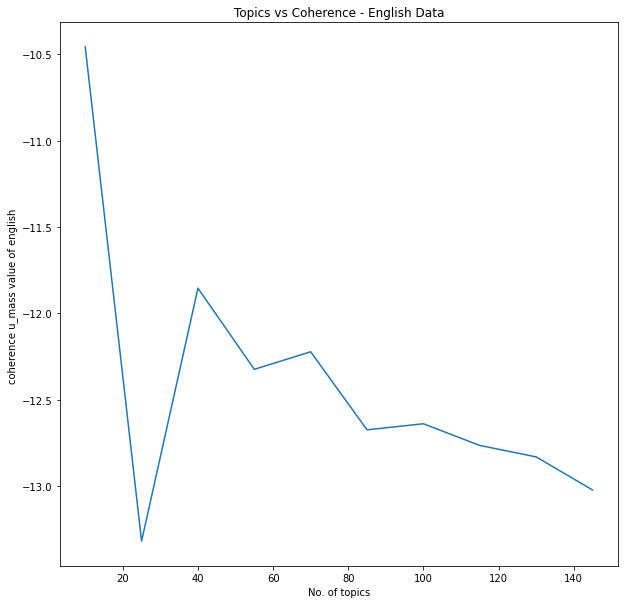

In [166]:
import matplotlib.pyplot as plt
import numpy as np

x1 = [10,25,40,55,70,85,100,115,130,145]
y1 = [-10.456997122169419, -13.320131917921834,-11.854983724796288, -12.32507318989637, -12.223220078287339, -12.675517017264244, -12.6403614362868, -12.765944383918393,-12.832263576242427,-13.023870218849522]
plt.subplots(figsize=(10, 10))
plt.plot(x1, y1)
plt.xlabel("No. of topics") # add X-axis label
plt.ylabel("coherence u_mass value of english ") # add Y-axis label
plt.title("Topics vs Coherence - English Data") # add title
plt.show()